Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


  0%|          | 0/28 [00:00<?, ?it/s]

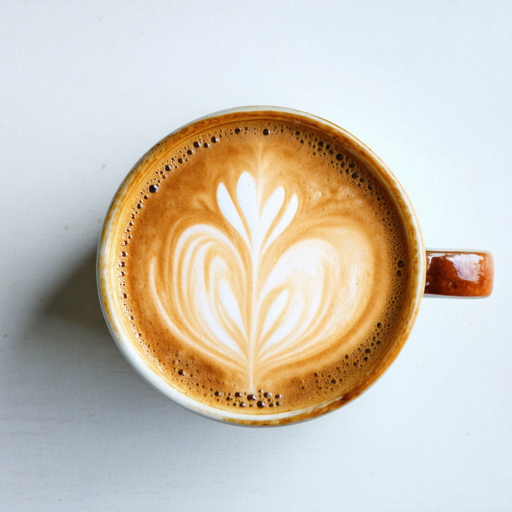

In [1]:
import torch
from pipeline_stable_diffusion_3 import StableDiffusion3Pipeline
from transformer_sd3 import SD3Transformer2DModel
transformer = SD3Transformer2DModel.from_pretrained("stabilityai/stable-diffusion-3.5-large", torch_dtype=torch.bfloat16, subfolder="transformer")
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large", torch_dtype=torch.bfloat16)
pipe.transformer = transformer
pipe = pipe.to("cuda")

image = pipe(
    "A coffee with CVPR logo on it",
    negative_prompt="hand",
    num_inference_steps=28,
    guidance_scale=4,
).images[0] 
image.resize((512, 512))


In [4]:
pipe.intermediate_latents[0].shape, pipe.intermediate_prompt_embeds[0].shape

(torch.Size([4096, 2432]), torch.Size([333, 2432]))

In [ ]:
class Module(torch.nn.Module):
    def __init__(self, head=8):
        super().__init__()
        self.latent_proj = torch.nn.Linear(2432, 512)
        self.prompt_proj = torch.nn.Linear(2432, 512)
        self.head = head
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(head, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(32, 16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(16, 4, kernel_size=3, padding=1),
        )
    
    def forward(self, latent, prompt):
        batch_size = latent.shape[0]
        latent = self.latent_proj(latent)
        prompt = self.prompt_proj(prompt)
        latent = latent.view(batch_size, -1, self.head, 512 // self.head)
        prompt = prompt.view(batch_size, -1, self.head, 512 // self.head)
        assert latent.shape[-2:] == prompt.shape[-2:]
        attention = torch.einsum("blhd,bnhd->bhl", latent, prompt)
        attention = attention.view(-1, self.head, 64, 64)
        res = self.conv(attention)
        # res = torch.nn.functional.interpolate(
        #     res, size=(128, 128), mode="bilinear", align_corners=False
        # )
        # upsampling should be done after sampling
        # res.shape[1]: cond_weight_mean, cond_weight_std, uncond_weight_mean, uncond_weight_std
        return res

In [50]:
module = Module()
res = module(pipe.intermediate_latents[0].unsqueeze(0).float(), pipe.intermediate_prompt_embeds[0].unsqueeze(0).float())